In [2]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import itertools
import random
import copy 
import matplotlib.pyplot as plt
from utils import Path
from tqdm import tqdm
import collections 

import elkai
from tsp_solver.greedy import solve_tsp
from python_tsp.exact import solve_tsp_dynamic_programming
import time 

In [9]:
class FourOpt(Path):
    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        start: int,
        iteration: int = 1,
        verbose: Optional[bool] = True):
            
        super().__init__(image,patch_size,verbose)
        self.start = start
        self.iteration = iteration
        self.history = []

    def get_statistics(self):
        """
        Plot the statistics of 4-opt
        """
        self.history = np.asarray(self.history)
        plt.figure(figsize=(15,10))
        ax = plt.subplot(111)
        for i in range(self.iteration):
            ax.plot(np.arange(self.history.shape[1]),self.history[i,:],label=f"route {i}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0+box.height*0.1,box.width,box.height*0.9]) # shrink axis height by 10%
        ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),fancybox=True,shadow=True,ncol=self.iteration//2)
        ax.set_title("4 Opt")
        ax.set_ylabel("Distance")
        ax.set_xlabel("Iteration")
        plt.show()

    def initialize(self):
        route = [self.start]
        route += random.sample(range(1,self.num_vertex), self.num_vertex-1)

        duplicates = [item for item, count in collections.Counter(route).items() if count > 1]
        if len(duplicates) != 0:
            print(duplicates)
            
        assert len(duplicates) == 0, f"Initialize error"

        return route
    
    def get_distance(self,route):
        dist = 0
        for i in range(self.num_vertex-1):
            dist += self.weight_matrix[route[i],route[i+1]]

        return dist
    
    def four_exchange(self,route,case,a,c,e,g):
        """
        In this exchange we consider only pure non-sequential 4-opt moves which there are only 5 cases

        # TODO
        (1) Check for duplicates in 4-opt
        """
        b,d,f,h = a+1, c+1, e+1, g+1
        p_a, p_b, p_c, p_d, p_e, p_f, p_g, p_h = [route[i] for i in [a,b,c,d,e,f,g,h]]
        base = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_h]

        # 2-opt cases
        if case == 1: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_h]

        if case == 2: #checked
            path = route[:a+1] + route[b:c+1] + route[d:e+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_h]

        if case == 3: #checked
            path = route[:a+1] + route[b:c+1] + route[e:d-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_f] + self.weight_matrix[p_g][p_h]

        if case == 4: #checked
            path = route[:a+1] + route[b:c+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_h]

        if case == 5: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_h]

        if case == 6: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[d:e+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_h]

        # 3-opt cases
        if case == 7: #checked
            path = route[:a+1] + route[f:g+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_h]

        if case == 8: #checked
            path = route[:a+1] + route[b:c+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_h]

        if case == 9: #checked
            path = route[:a+1] + route[b:c+1] + route[f:g+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_h]

        if case == 10: #checked
            path = route[:a+1] + route[b:c+1] + route[f:g+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_d][p_h]

        if case == 11: #checked
            path = route[:a+1] + route[b:c+1] + route[g:f-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_b] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_h]

        if case == 12: #checked
            path = route[:a+1] + route[d:e+1] + route[f:g+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_h]

        if case == 13: #checked
            path = route[:a+1] + route[d:e+1] + route[f:g+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_h]

        if case == 14: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_h]

        if case == 15: #checked
            path = route[:a+1] + route[f:g+1] + route[b:c+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_h]

        if case == 16: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[b:c+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_d] + self.weight_matrix[p_e][p_h]

        if case == 17: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[c:b-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_h]

        if case == 18: #checked
            path = route[:a+1] + route[d:e+1] + route[c:b-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_h]

        if case == 19: #checked
            path = route[:a+1] + route[d:e+1] + route[b:c+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_f] + self.weight_matrix[p_g][p_h]

        if case == 20: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[b:c+1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_g][p_h]

        if case == 21: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[e:d-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_c][p_h]

        if case == 22: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[f:g+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_g][p_h]

        # 4-opt cases
        if case == 23: #checked
            path = route[:a+1] + route[f:g+1] + route[d:e+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_h]

        if case == 24: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_h]

        if case == 25: #checked
            path = route[:a+1] + route[d:e+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_h]

        if case == 26: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[f:g+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_f] + self.weight_matrix[p_c][p_g] + self.weight_matrix[p_b][p_h]

        if case == 27: #checked
            path = route[:a+1] + route[d:e+1] + route[g:f-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_h]

        if case == 28: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[f:g+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_c][p_h]

        if case == 29: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[f:g+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_d][p_h]

        if case == 30: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_h]

        if case == 31: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[f:g+1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_h]

        if case == 32: #checked
            path = route[:a+1] + route[f:g+1] + route[b:c+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_b] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_d][p_h]

        if case == 33: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[b:c+1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_e] + self.weight_matrix[p_d][p_h]

        if case == 34: #checked
            path = route[:a+1] + route[d:e+1] + route[c:b-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_g] + self.weight_matrix[p_f][p_h]
                
        if case == 35: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_d][p_h]

        if case == 36: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[c:b-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_h]

        if case == 37: #checked
            path = route[:a+1] + route[d:e+1] + route[b:c+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_f][p_h]

        if case == 38: #checked
            path = route[:a+1] + route[e:d-1:-1] + route[b:c+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_f][p_h]

        if case == 39: #checked
            path = route[:a+1] + route[f:g+1] + route[c:b-1:-1] + route[d:e+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_h]

        if case == 40: #checked
            path = route[:a+1] + route[f:g+1] + route[e:d-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_e] + self.weight_matrix[p_d][p_b] + self.weight_matrix[p_c][p_h]
        
        if case == 41: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[d:e+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_h]
        
        if case == 42: #checked
            path = route[:a+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_h]
           
        if case == 43: #checked
            path = route[:a+1] + route[g:f-1:-1] + route[d:e+1] + route[c:b-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_g] + self.weight_matrix[p_f][p_d] + self.weight_matrix[p_e][p_c] + self.weight_matrix[p_b][p_h]

        if case == 44: #checked 
            path = route[:a+1] + route[e:d-1:-1] + route[g:f-1:-1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_e] + self.weight_matrix[p_d][p_g] + self.weight_matrix[p_f][p_b] + self.weight_matrix[p_c][p_h]

        if case == 45: #checked
            path = route[:a+1] + route[f:g+1] + route[c:b-1:-1] + route[e:d-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_c] + self.weight_matrix[p_b][p_e] + self.weight_matrix[p_d][p_h]

        if case == 46:
            path = route[:a+1] + route[f:g+1] + route[d:e+1] + route[b:c+1] + route[h:]
            cost = self.weight_matrix[p_a][p_f] + self.weight_matrix[p_g][p_d] + self.weight_matrix[p_e][p_b] + self.weight_matrix[p_c][p_h]

        if case == 47:
            path = route[:a+1] + route[c:b-1:-1] + route[d:e+1] + route[g:f-1:-1] + route[h:]
            cost = self.weight_matrix[p_a][p_c] + self.weight_matrix[p_b][p_d] + self.weight_matrix[p_e][p_g] + self.weight_matrix[p_f][p_h]


        duplicates = [item for item, count in collections.Counter(path).items() if count > 1]
        if len(duplicates) != 0:
            print(path)
            print(duplicates)

        assert len(duplicates) == 0, f"Case {case}: path change error"
        return path, base-cost
        

    def four_opt(self,route: List[int],num_iteration: Optional[int] = None):
        
        iteration = 0
        self.history.append(self.get_distance(route))
        for a in tqdm(range(self.num_vertex-7)):
            for c in range(a+2,len(route)-5):
                for e in range(c+2,len(route)-3):
                    for g in range(e+2,len(route)-1):
                        temp_route = copy.deepcopy(route)
                        base_change = 0
                        for i in range(1,48):
                            path, change = self.four_exchange(temp_route,i,a,c,e,g)
                            if change > base_change:
                                route = path
                                base_change = change

                            iteration += 1


        return route
        
    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []   
        for i, g in enumerate(self.all_graphs):
            route = self.initialize()
            path = self.four_opt(route)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p
        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)
            self.all_path_converted = []        

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[crack_order[-1]])

            return path


Preprocessing of graph completed


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:57<00:00,  1.48s/it]


[287, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 358, 359, 358, 357, 327, 326, 325, 324, 323, 353, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 344, 314, 313, 343, 342, 372, 371, 341, 340, 339, 369, 370, 369, 368, 338, 337, 367, 366, 365, 364, 365, 335, 334, 333, 332, 331, 361, 360, 361, 362, 361]
46
272 144 16 192
(64, 18, 0)


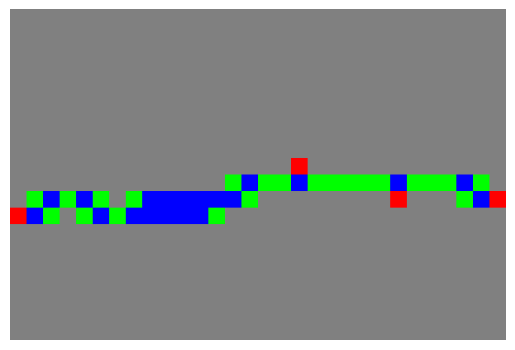

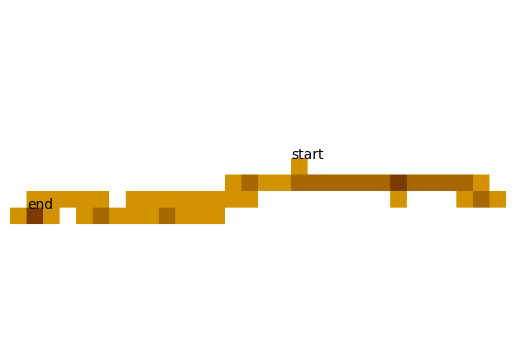

In [13]:
if __name__ == "__main__":

    img = cv2.imread("./binary_image/4.png",cv2.IMREAD_UNCHANGED) 
    ps = (16,16)
    x = FourOpt(img,ps,0,1,True)
    path = x._optimize()  
    print(path)
    print(x.num_vertex)
    print(x.check_all_path())
    # x.get_statistics()